## Installing Modules

In [1]:
!pip install pytorch_lightning torchmetrics tableprint spacy==3
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

2021-06-30 15:21:43.265983: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2021-06-30 15:21:50.793080: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


## Imports

In [2]:
# Import Libraries
import random
from typing import Iterable, List, Tuple
import pandas as pd
import sys, os, pickle
import numpy as np
import math
import matplotlib.pyplot  as plt
import matplotlib.ticker as ticker

import spacy

# PyTorch related
import torch, torchtext
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# My Custom Code
import pytorch_lightning as pl
import torchmetrics
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import tableprint as tp



/usr/local/lib/python3.7/dist-packages/pytorch_lightning/metrics/__init__.py:44: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  "`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package"


In [3]:
# Manual Seed
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Language Definitions

In [5]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

## Tokenizers

In [6]:
token_transform[SRC_LANGUAGE]  = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

## Yield Function

This yields the tokens for the texts and will be used to build the vocab

In [7]:
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

## Special Tokens

In [8]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

Build the vocab here

In [9]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  # Training data Iterator 
  train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  # Create torchtext's Vocab object 
  vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

### Setting the default index as the <unk> token

In [10]:
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [11]:
len(vocab_transform['de'])

19215

In [12]:
len(vocab_transform['en'])

10838

## Collator

In [13]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))
    
    src_lengths = torch.LongTensor([len(x) for x in src_batch])
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, src_lengths, tgt_batch

## DataLoader

In [14]:
BATCH_SIZE = 32
train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_loader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_loader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_loader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=1)

## Model

### Boilerplate Code for PyTorch Lightning

In [15]:
class TL(pl.LightningModule):
    def __init__(self):
        super(TL, self).__init__()

        self.train_acc =  torch.tensor(0.)
        self.avg_train_loss = torch.tensor(0.)
        self.table_context = None
        

    def training_step(self, batch, batch_idx):
        src, src_lengths, trg = batch
        output = self(src, src_lengths, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss_train = self.loss(output, trg)
        return loss_train
    
    def validation_step(self, batch, batch_idx):
        src, src_lengths, trg = batch
        output = self(src, src_lengths, trg, 0)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss_valid = self.loss(output, trg) 
        return {"loss": loss_valid}
    
    def training_epoch_end(self, outputs):
        self.avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
    
    def validation_epoch_end(self, outputs):
        if trainer.sanity_checking:
          print('sanity check')
          return
        avg_valid_loss = torch.stack([x['loss'] for x in outputs]).mean()
        metrics = {'epoch': self.current_epoch+1, 'Train PPL': math.exp(self.avg_train_loss), 'Train Loss': self.avg_train_loss,  'Valid PPL': math.exp(avg_valid_loss), 'Valid Loss': avg_valid_loss}
        if self.table_context is None:
          self.table_context = tp.TableContext(headers=['epoch', 'Train PPL', 'Train Loss', 'Valid PPL', 'Valid Loss'])
          self.table_context.__enter__()
        self.table_context([self.current_epoch+1, math.exp(self.avg_train_loss.item()), self.avg_train_loss.item(), math.exp(avg_valid_loss.item()), avg_valid_loss.item()])
        self.logger.log_metrics(metrics)
        if self.current_epoch == self.trainer.max_epochs - 1:
          self.validation_end(outputs)
    
    def validation_end(self, outputs):
        self.table_context.__exit__()

### Encoder

In [16]:
class Encoder(pl.LightningModule):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.hid_dim = enc_hid_dim
        
        self.embedding = nn.Embedding(input_dim, emb_dim)  
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        embedded = self.dropout(self.embedding(src))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.to('cpu'), enforce_sorted=False)
        packed_outputs, hidden = self.rnn(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        return output, hidden

## Attention

In [17]:
class Attention(pl.LightningModule):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
        
    def forward(self, hidden, encoder_outputs, mask):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)      
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 

        attention = self.v(energy).squeeze(2)
        attention = attention.masked_fill(mask == 0, -1e10)        
        return F.softmax(attention, dim=1)


### Decoder

In [18]:
class Decoder(pl.LightningModule):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.attention = attention



        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        input = input.unsqueeze(0)        
        embedded = self.dropout(self.embedding(input))
               
        a = self.attention(hidden, encoder_outputs, mask)
                       
        a = a.unsqueeze(1)
                
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
                
        weighted = torch.bmm(a, encoder_outputs)
                
        weighted = weighted.permute(1, 0, 2)
                
        rnn_input = torch.cat((embedded, weighted), dim = 2)
                    
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
                
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq Model

In [19]:
# Define the model

class Seq2Seq(TL):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super(Seq2Seq, self).__init__()
        
        self.loss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
        self.lr = 1e-3
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        # self.device = device # Doesn't work in PyTorchLightning since it is already defined!

    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask

    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src, src_len)
                        
        input = trg[0,:]
        mask = self.create_mask(src)
        for t in range(1, trg_len):
            
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = output.argmax(1) 
            
            input = trg[t] if teacher_force else top1

        return outputs
    
    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters())
        return optim

## Model Initialization and Summary

In [20]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TGT_LANGUAGE])

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

SRC_PAD_IDX = PAD_IDX


attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)


model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

### Model Checkpoint

In [21]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/content',
    filename='sst-{epoch:02d}-{val_loss:.2f}',
    mode='min'
)

In [22]:
!rm -rf csv_logs
csvlogger = CSVLogger('csv_logs', name='END2_Assign_8', version=0)
trainer = pl.Trainer(max_epochs=20, num_sanity_val_steps=1, logger=csvlogger, gpus=1, callbacks=[checkpoint_callback], gradient_clip_val=1, gradient_clip_algorithm='norm')
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)
checkpoint_callback.best_model_path

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type             | Params
---------------------------------------------
0 | loss    | CrossEntropyLoss | 0     
1 | encoder | Encoder          | 7.8 M 
2 | decoder | Decoder          | 25.8 M
---------------------------------------------
33.6 M    Trainable params
0         Non-trainable params
33.6 M    Total params
134.238   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:42: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  'Your `IterableDataset` has `__len__` defined.'


sanity check


╭─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│       epoch │   Train PPL │  Train Loss │   Valid PPL │  Valid Loss │
├─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│           1 │      48.257 │      3.8765 │      42.721 │      3.7547 │


│           2 │      18.446 │      2.9148 │      40.698 │      3.7062 │


│           3 │      12.116 │      2.4945 │      44.254 │      3.7899 │


│           4 │      9.3659 │      2.2371 │      46.699 │      3.8437 │


│           5 │      8.1912 │      2.1031 │      51.489 │      3.9414 │


│           6 │      7.3295 │      1.9919 │      54.291 │      3.9944 │


│           7 │      6.7827 │      1.9144 │      57.387 │      4.0498 │


│           8 │      6.3954 │      1.8556 │      60.835 │      4.1082 │


│           9 │      6.0529 │      1.8005 │      62.706 │      4.1385 │


│          10 │      5.8646 │      1.7689 │      67.658 │      4.2145 │


│          11 │       5.675 │      1.7361 │      69.946 │      4.2477 │


│          12 │      5.5387 │      1.7118 │      71.308 │       4.267 │


│          13 │      5.5132 │      1.7071 │      73.567 │      4.2982 │


│          14 │      5.3332 │       1.674 │      77.858 │      4.3549 │


│          15 │      5.2239 │      1.6532 │      82.546 │      4.4134 │


│          16 │      5.1997 │      1.6486 │      82.385 │      4.4114 │


│          17 │      5.0924 │      1.6278 │      85.675 │      4.4506 │


│          18 │      5.0103 │      1.6115 │      90.424 │      4.5045 │


│          19 │      4.9989 │      1.6092 │      91.238 │      4.5135 │


│          20 │      4.9658 │      1.6026 │      91.657 │       4.518 │
╰─────────────┴─────────────┴─────────────┴─────────────┴─────────────╯



''

In [23]:
torch.save(model.state_dict(), '/content/model_e2_n4.pth')

## Training Log

In [24]:
root='./csv_logs/' + 'END2_Assign_8' + '/'
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
metricfile = root + dirlist[-1:][0] + '/metrics.csv'
metrics = pd.read_csv(metricfile)

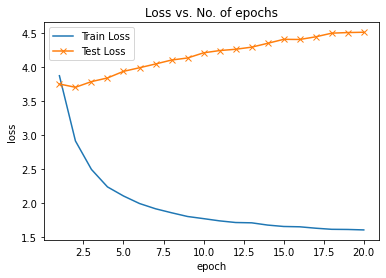

In [25]:
plt.plot(metrics['epoch'], metrics['Train Loss'], label="Train Loss")
plt.plot(metrics['epoch'], metrics['Valid Loss'], '-x', label="Test Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss vs. No. of epochs');

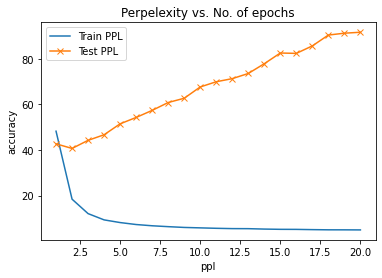

In [26]:
plt.plot(metrics['epoch'], metrics['Train PPL'], label="Train PPL")
plt.plot(metrics['epoch'], metrics['Valid PPL'], '-x', label="Test PPL")
plt.xlabel('ppl')
plt.ylabel('accuracy')
plt.legend()
plt.title('Perpelexity vs. No. of epochs');

## Inference on Random Samples from Test Data

In [27]:
model.to(device)
model.eval()

Seq2Seq(
  (loss): CrossEntropyLoss()
  (encoder): Encoder(
    (embedding): Embedding(19215, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(10838, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=10838, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [28]:
def translate_sentence(src_sent_tok, model, device, max_len = 50):

    model.eval()

    src_tensor = torch.LongTensor(src_sent_tok).unsqueeze(1).to(device)
    src_len = torch.LongTensor([len(src_sent_tok)])
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [BOS_IDX]

    attentions = torch.zeros(max_len, 1, len(src_sent_tok)).to(device)
    
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == EOS_IDX:
            break
    
    trg_tokens = [vocab_transform['en'].lookup_token(i) for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [29]:
i = np.random.randint(0,32,1).item()
src_sent_i = next(iter(test_loader))[0][:,i]
trg_sent_i = next(iter(test_loader))[2][:,i]
stop_ind_src = (src_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
stop_ind_trg = (trg_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
src_sent_i = src_sent_i[:stop_ind_src+1]
trg_sent_i = trg_sent_i[:stop_ind_trg+1]
src_sent_tok = [vocab_transform['de'].lookup_token(word_i) for word_i in src_sent_i[1:stop_ind_src]]
trg_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in trg_sent_i[1:stop_ind_trg]]
src_sent = " ".join(src_sent_tok[1:]) # skip the initial <bos> token
trg_sent = " ".join(trg_sent_tok[1:]) # skip the initial <bos> token

In [30]:
translation, attention = translate_sentence(src_sent_i, model, device, max_len = 50)

In [31]:
pred_sent = " ".join(translation)
start = "\033[1m"
end = "\033[0;0m"
print(f'{start}Source Sentence: {end}{src_sent}')
print(f'{start}Target Sentence: {end}{trg_sent}')
print(f'{start}Translated Sentence: {end}{pred_sent}')

Source Sentence: Mädchen in einem Jeanskleid läuft über einen erhöhten Schwebebalken .
Target Sentence: girl in a jean dress is walking along a raised balance beam .
Translated Sentence: A girl in a baby is walking a raised . <eos>


## Attention

In [32]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
     
    attention = attention.squeeze(1).cpu().detach().numpy()
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    
    x_ticks = [''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>']
    y_ticks = [''] + translation
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

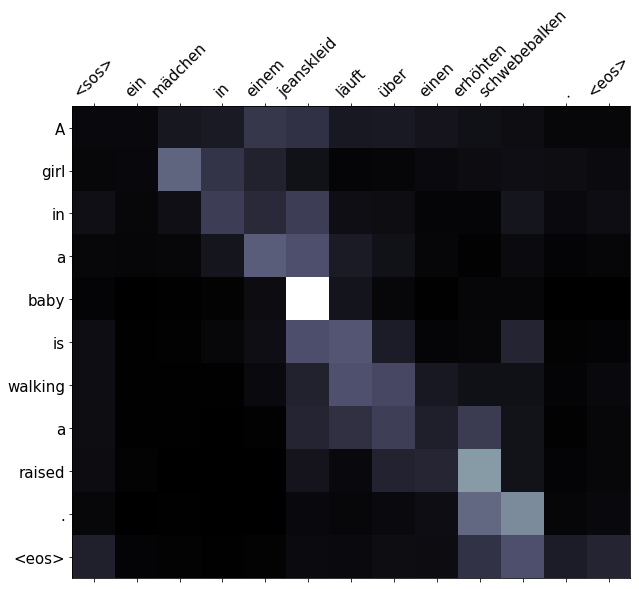

In [33]:
display_attention(src_sent_tok, translation, attention)

## BLEU Scores

In [34]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data_loader, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    

    for datum in data_loader:
        for c in range(datum[1].size()[0]):
          src_sent_i = next(iter(test_loader))[0][:,c]
          trg_sent_i = next(iter(test_loader))[2][:,c]
          stop_ind_src = (src_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
          stop_ind_trg = (trg_sent_i==3).nonzero()[0].item() # stop when <eos> token is found
          src_sent_i = src_sent_i[:stop_ind_src+1]
          trg_sent_i = trg_sent_i[:stop_ind_trg+1]
          src_sent_tok = [vocab_transform['de'].lookup_token(word_i) for word_i in src_sent_i[1:stop_ind_src]]
          trg_sent_tok = [vocab_transform['en'].lookup_token(word_i) for word_i in trg_sent_i[1:stop_ind_trg]]
          src_sent = " ".join(src_sent_tok[1:]) # skip the initial <bos> token
          trg_sent = " ".join(trg_sent_tok[1:]) # skip the initial <bos> token        
          
          pred_trg, _ = translate_sentence(src_sent_i, model, device, max_len = 50)

          #cut off <eos> token
          pred_trg = pred_trg[:-1]
          
          pred_trgs.append(pred_trg)
          trgs.append([trg_sent_tok])
        
    return bleu_score(pred_trgs, trgs)

In [36]:
bleu_score = calculate_bleu(test_loader, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 26.75
